# 导入库
## 可以修改模型 model、model_2
## 可以修改数据集 dataset1、dataset2


In [2]:
import numpy as np
import pandas as pd
import datetime
import time
from model import Net1
import torch.optim as optim
from scipy import io
import argparse
import os                    # nn.BatchNorm2d(2,affine=False),
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import h5py  
import matplotlib.pyplot as plt
import h5py  
import matplotlib
from PIL import Image
import math
from sklearn.metrics import confusion_matrix
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import itertools
import ParaSetting
import platform


同步cuda
记录开始时间
设置使用的GPU（若有多个GPU才会生效）
优先选择gpu否则使用cpu并打印设备
定义read_h5布尔变量值为1

In [3]:

torch.cuda.synchronize()
starttime = time.time()

os.environ["CUDA_VISIBLE_DEVICES"]="0" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
read_h5 = True 


cuda


# 数据预处理

In [4]:

## Working path define


if platform.system() == 'Windows':
    root_ws   = os.getcwd()

else:
    root_ws = ParaSetting.root_ws

expname  = ParaSetting.expname

modelpath =  r'D:\Ultra-low-field-MRI-Scanner-main\hku__EMI\model'

modelpath = root_ws+"\\"+'model\\'


epoch_num_char = str(ParaSetting.epoch_num)

datapath  = root_ws+"\\DataHub\\"+expname+'data\\'

os.makedirs(modelpath, exist_ok=True)
os.makedirs(datapath, exist_ok=True)


In [5]:

## Hyperparameters
epoch_num = ParaSetting.epoch_num #iteration number 
Nx = ParaSetting.Nx
bs = ParaSetting.bs  # batch size

lr = ParaSetting.lr
lr_update = ParaSetting.lr_update
weight_decay = 0.000


In [8]:


class prepareData_train(Dataset):
    def __init__(self, train_or_test):

       self.files = os.listdir(datapath+train_or_test)
       self.train_or_test= train_or_test
       print(f"Number of files in {train_or_test}: {len(self.files)}")
    def __len__(self):
       return len(self.files)

    def __getitem__(self, idx):
        
        data = torch.load(datapath+self.train_or_test+'/'+self.files[idx])  ##windows要用\\
        return data['k-space'],  data['label']

 

In [9]:
   
trainset = prepareData_train('train')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,shuffle=True, num_workers=0)

validationset = prepareData_train('validation')
validationloader = torch.utils.data.DataLoader(validationset, batch_size=bs,shuffle=True, num_workers=0)


Number of files in train: 6854
Number of files in validation: 1210


# 定义神经网络模型
# 定义损失函数和优化器

In [16]:

model = Net1().to(device)
print(model)

criterion1 = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



Net1(
  (features): Sequential(
    (0): Conv2d(2, 128, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 2, kernel_size=(7, 7), stride=(1, 4), padding=(3, 0))
  )
)


# 训练循环
 optimizer.zero_grad()  # 清空梯度
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数



前向传播：outs = model(inputs)
计算损失：loss = criterion1(outs, labels)
清空梯度：optimizer.zero_grad()
反向传播：loss.backward()
更新模型参数：optimizer.step()

将 PyTorch 的张量类型的损失转换为 Python 的标量值： loss.item()
记录每个批次的损失值便于打印： loss_batch.append(loss.item())组成一个一维n个数据的向量



In [21]:
loss_train_list = []
loss_validation_list = []



for epoch in range(epoch_num):   
    
    
    model.train()
    loss_batch = []
    
    for i, data in enumerate(trainloader, 0):
        
        
        # 获取输入和标签数据
        inputs = data[0].reshape(-1,2,Nx,10).to(device)
        labels = data[1].reshape(-1,2,Nx,1).to(device)

        # 前向传播
        outs = model(inputs)
        
        # 计算损失
        loss = criterion1(outs, labels)

        # 反向传播并优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_batch.append(loss.item())  
        
        if (i) % 20 == 0:
            print('epoch:%d - %d, loss:%.10f' % (epoch+1, i+1, loss.item()))
    
    loss_train_list.append(round(sum(loss_batch) / len(loss_batch), 10))
    print(loss_train_list)

    model.eval()  # 切换到验证模式
    
    loss_batch = []
    print('\nTesting...')
    
    for i, data in enumerate(validationloader, 0):

        
        # 获取输入和标签数据
        inputs = data[0].reshape(-1,2,Nx,10).to(device)
        labels = data[1].reshape(-1,2,Nx,1).to(device)
    
        with torch.no_grad():
            outs = model(inputs)
        
        loss = criterion1(outs, labels)
        loss_batch.append(loss.item())
        
    loss_validation_list.append(round(sum(loss_batch) / len(loss_batch), 10))
    print(loss_validation_list)


    # 如果是最后一个epoch，保存模型
    if (epoch+1) == epoch_num:
        today = datetime.datetime.today().strftime('%Y-%m-%d')
        filename = 'epoch-%d-%s.pth' % (epoch+1, today)
        torch.save(model, os.path.join(modelpath, filename))

    # 每4个epoch更新学习率
    if (epoch+1) % 4 == 0:
        lr = min(2e-5, lr*lr_update) 
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


epoch:1 - 1, loss:125.1573638916
epoch:1 - 21, loss:67.2365264893
epoch:1 - 41, loss:41.5831298828
epoch:1 - 61, loss:27.9661712646
epoch:1 - 81, loss:16.8693618774
epoch:1 - 101, loss:12.9474124908
epoch:1 - 121, loss:8.6925382614
epoch:1 - 141, loss:7.3381872177
epoch:1 - 161, loss:6.1167535782
epoch:1 - 181, loss:5.1739912033
epoch:1 - 201, loss:4.7316637039
epoch:1 - 221, loss:4.3619232178
epoch:1 - 241, loss:4.0985136032
epoch:1 - 261, loss:3.7678771019
epoch:1 - 281, loss:3.8330340385
epoch:1 - 301, loss:3.7544038296
epoch:1 - 321, loss:3.4956703186
epoch:1 - 341, loss:3.6320548058
epoch:1 - 361, loss:3.4194970131
epoch:1 - 381, loss:3.4773406982
epoch:1 - 401, loss:3.3595972061
epoch:1 - 421, loss:3.1242480278
[13.5166906393]

Testing...
[3.5382606105]
epoch:2 - 1, loss:3.3856418133
epoch:2 - 21, loss:3.0284485817
epoch:2 - 41, loss:3.2244756222
epoch:2 - 61, loss:3.0956885815
epoch:2 - 81, loss:3.1251969337
epoch:2 - 101, loss:2.9856171608
epoch:2 - 121, loss:2.9972300529
epoch

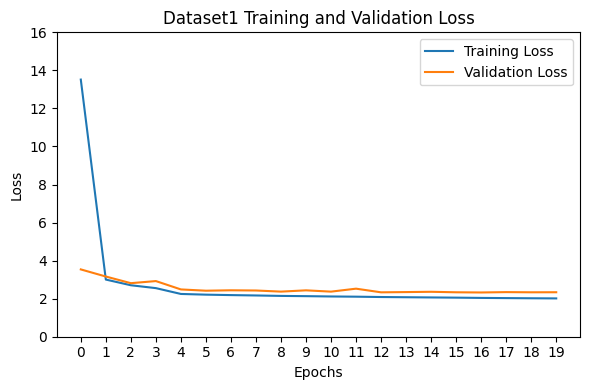

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
from datetime import datetime
import os

loss_train_list = [13.5166906393, 3.0044995666, 2.7054711833, 2.5542890253, 2.2481301726, 2.2113179933, 2.1879536227, 2.1686916443, 2.1450923192, 2.1323267563, 2.1157114611, 2.1048186167, 2.0867198208, 2.0757732694, 2.0648186407, 2.0539548519, 2.0399003168, 2.0303489956, 2.0213996175, 2.0137884584]
loss_validation_list = [3.5382606105, 3.1641366105, 2.8146454849, 2.9251766456, 2.4857996796, 2.4187600644, 2.4406010822, 2.4295719799, 2.3709876349, 2.4379475368, 2.3699219007, 2.5258639235, 2.333792081, 2.3466686544, 2.3616009794, 2.3357886609, 2.3257687531, 2.3445423622, 2.3352412613, 2.3382367931]

epochs = range(0, 20)

# 绘制损失曲线
plt.figure(figsize=(6, 4))

plt.plot(epochs, loss_train_list, label='Training Loss')
plt.plot(epochs, loss_validation_list, label='Validation Loss')
plt.title('Dataset1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# 设置y轴范围为1.5到16.3
plt.ylim(0, 16) 

# 设置横轴刻度为整数
plt.xticks(epochs)  # 使用 epochs 作为横轴刻度，确保显示整数

# 添加图例
plt.legend()

# 显示图形
plt.tight_layout()
plt.show()


today = datetime.today().strftime('%Y-%m-%d')

# 文件夹路径，假设你想保存到某个路径，比如 '/path/to/folder'
folder_path = r'D:\Ultra-low-field-MRI-Scanner-main\hku__EMI\figures'

# 生成文件名
filename = f'{today}_Dataset1.png'

# 创建完整的文件路径
file_path = os.path.join(folder_path, filename)

plt.savefig(file_path)


In [6]:
print(f"Training set size: {len(trainset)}")
print(f"Batch size: {bs}")

NameError: name 'trainset' is not defined

In [ ]:

torch.cuda.synchronize()
endtime = time.time()
print('Finished Training. Training time elapsed %.2fs.' %(endtime-starttime))

